# Introduction à la classification : des images de vêtements

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
 
  </td>
</table>

Ce guide forme un modèle de réseau neuronal pour classer les images de vêtements, comme les baskets et les chemises. Ce n'est pas grave si vous ne comprenez pas tous les détails; il s'agit d'un aperçu rapide d'un programme TensorFlow complet avec les détails expliqués au fur et à mesure.

Ce guide utilise [tf.keras](https://www.tensorflow.org/guide/keras), une API de haut niveau pour créer et former des modèles dans TensorFlow. 

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


## Importer le dataset Fashion MNIST

 Ce guide utilise le jeu de données [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) qui contient 70 000 images en niveaux de gris dans 10 catégories. Les images montrent des vêtements individuels à basse résolution (28 par 28 pixels), comme on le voit ici :

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST est conçu pour remplacer l'ensemble de données [MNIST](http://yann.lecun.com/exdb/mnist/) classique, souvent utilisé comme "Hello, World" des programmes d'apprentissage automatique pour la vision par ordinateur. Le jeu de données MNIST contient des images de chiffres manuscrits (0, 1, 2, etc.) dans un format identique à celui des vêtements que vous utiliserez ici.

Ce guide utilise Fashion MNIST pour la variété et parce que c'est un problème légèrement plus difficile que le MNIST ordinaire. Les deux ensembles de données sont relativement petits et sont utilisés pour vérifier qu'un algorithme fonctionne comme prévu. Ce sont de bons points de départ pour tester et déboguer le code.

Ici, 60 000 images sont utilisées pour former le réseau et 10 000 images pour évaluer la précision avec laquelle le réseau a appris à classer les images. Vous pouvez accéder au Fashion MNIST directement depuis TensorFlow. Importez et chargez les données [Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directement depuis TensorFlow :

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Le chargement de l'ensemble de données renvoie quatre tableaux NumPy :

* Les tableaux `train_images` et `train_labels` sont l'*ensemble d'apprentissage* - les données que le modèle utilise pour apprendre.
* Le modèle est testé par rapport à l'*ensemble de tests*, aux tableaux `test_images` et `test_labels`.

Les images sont des tableaux NumPy 28x28, avec des valeurs de pixels allant de 0 à 255. Les *étiquettes* sont un tableau d'entiers, allant de 0 à 9. Ceux-ci correspondent à la *classe* de vêtements que l'image représente :


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Chaque image est associée à une seule étiquette. Étant donné que les *noms de classe* ne sont pas inclus dans le jeu de données, stockez-les ici pour les utiliser ultérieurement lors du traçage des images :


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explorer les données

Explorons le format de l'ensemble de données avant de former le modèle. L'exemple suivant montre qu'il y a 60 000 images dans l'ensemble d'apprentissage, chaque image étant représentée en 28 x 28 pixels :

In [4]:
train_images.shape

(60000, 28, 28)

De même, il y a 60 000 libellés dans l'ensemble d'apprentissage :

In [5]:
len(train_labels)

60000

Chaque étiquette est un entier compris entre 0 et 9 :

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Il y a 10 000 images dans le jeu de test. Encore une fois, chaque image est représentée en 28 x 28 pixels :

In [7]:
test_images.shape

(10000, 28, 28)

Et le jeu de test contient 10 000 étiquettes d'images :

In [8]:
len(test_labels)

10000

## Prétraiter les données

Les données doivent être prétraitées avant de former le réseau. Si vous inspectez la première image de l'ensemble d'apprentissage, vous verrez que les valeurs de pixel se situent dans la plage de 0 à 255 :

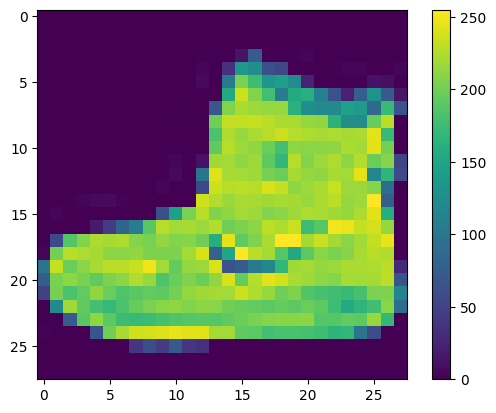

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Mettez ces valeurs à l'échelle dans une plage de 0 à 1 avant de les alimenter au modèle de réseau neuronal. Pour ce faire, divisez les valeurs par 255. Il est important que l'*ensemble d'apprentissage* et l'*ensemble de test* soient prétraités de la même manière :

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Pour vérifier que les données sont au format correct et que vous êtes prêt à construire et former le réseau, affichons les 25 premières images de l'*ensemble d'entraînement* et affichons le nom de la classe sous chaque image.

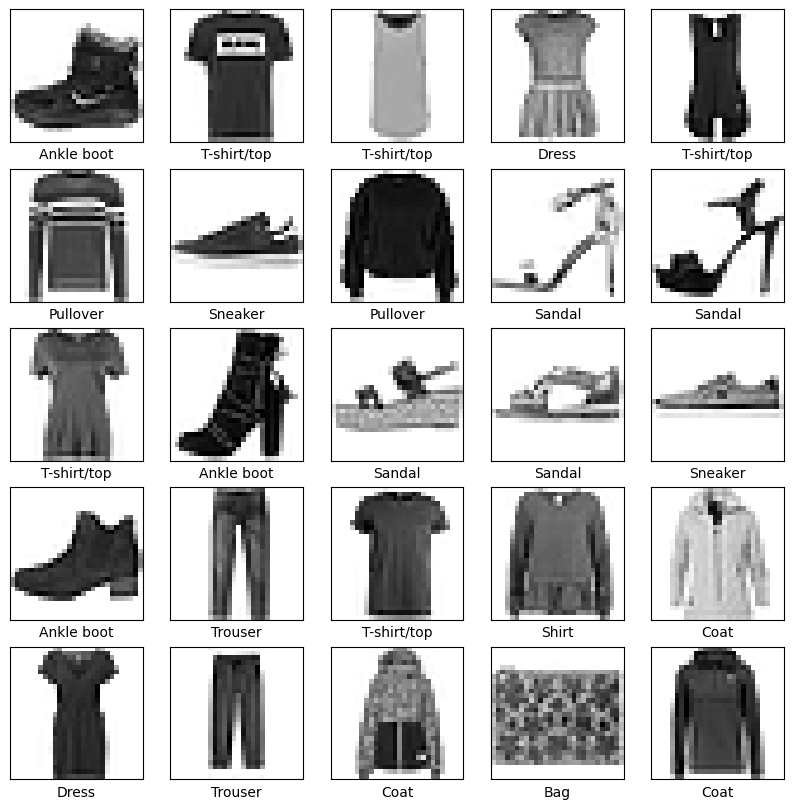

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Un premier modèle avec un réseau Dense (DNN)

Dans cette première étape, nous allons construire le réseau de neurones avec un modèle dense (DNN).

### Mettre en place des couches

Le bloc de construction de base d'un réseau de neurones est la [*couche*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Les couches extraient des représentations des données qui y sont introduites. Espérons que ces représentations sont significatives pour le problème à résoudre.

L'essentiel de l'apprentissage en profondeur consiste à enchaîner des couches simples. La plupart des couches, telles que `tf.keras.layers.Dense`, ont des paramètres appris lors de la formation.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

La première couche de ce réseau, `tf.keras.layers.Flatten`, transforme le format des images d'un tableau bidimensionnel (de 28 par 28 pixels) en un tableau unidimensionnel (de 28 * 28 = 784 pixels). Considérez ce calque comme désempilant des rangées de pixels dans l'image et en les alignant. Cette couche n'a aucun paramètre à apprendre ; il ne fait que reformater les données.

Une fois les pixels aplatis, le réseau se compose d'une séquence de deux couches `tf.keras.layers.Dense`. Ce sont des couches neuronales densément connectées ou entièrement connectées. La première couche `Dense` compte 128 nœuds (ou neurones). La deuxième (et dernière) couche renvoie un tableau logits d'une longueur de 10. Chaque nœud contient un score indiquant que l'image actuelle appartient à l'une des 10 classes.

Nous appelons ce modèle **dense** car tous les neurones d'une couche sont connectés à la sortie de tous les neurones de la couche précédente. Ainsi, par exemple, le premier neurone de la couche de sortie reçoit les informations de tous les 128 neurones de la couche intermédiaire. Ce type de réseau peut présenter des limitations tant en performance qu'en généralisation. 


### Compiler le modèle

Avant que le modèle ne soit prêt pour l'entraînement, il a besoin de quelques réglages supplémentaires. Ceux-ci sont ajoutés lors de l'étape de compilation du modèle :

* [*Fonction de perte*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) : mesure la précision du modèle pendant l'entraînement. Vous souhaitez minimiser cette fonction pour "orienter" le modèle dans la bonne direction.
*[*Optimiseur*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) : c'est ainsi que le modèle est mis à jour en fonction des données qu'il voit et de sa fonction de perte.
*[*Métriques*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)  : utilisées pour surveiller les étapes de formation et de test. L'exemple suivant utilise l'*accuracy*, la fraction des images qui sont correctement classées.


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Entraîner le modèle

L'entraînement du modèle de réseau neuronal nécessite les étapes suivantes :

1. Transférez les données de formation au modèle. Dans cet exemple, les données d'apprentissage se trouvent dans les tableaux `train_images` et `train_labels`.
2. Le modèle apprend à associer des images et des étiquettes.
3. Vous demandez au modèle de faire des prédictions sur un jeu de test — dans cet exemple, le tableau `test_images`.
4. Vérifiez que les prédictions correspondent aux étiquettes du tableau `test_labels`.


### Alimenter le modèle avec des données

Pour commencer l'entraînement, appelez la méthode [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), ainsi appelée car elle "adapte" le modèle aux données d'entraînement :

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 5ms/step - loss: 0.5001 - accuracy: 0.8253
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3763 - accuracy: 0.8653
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3389 - accuracy: 0.8770
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3148 - accuracy: 0.8842
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2966 - accuracy: 0.8904
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2802 - accuracy: 0.8974
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2684 - accuracy: 0.9008
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2569 - accuracy: 0.9040
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2496 - accuracy: 0.9066
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.23

Au fur et à mesure que le modèle s'entraîne, les métriques de perte et de précision sont affichées. Ce modèle atteint une précision d'environ 0,91 (ou 91%) sur les données d'apprentissage.

### Évaluer l'accuracy

Ensuite, comparez les performances du modèle sur l'ensemble de données de test :

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3622 - accuracy: 0.8721 - 697ms/epoch - 2ms/step

Test accuracy: 0.8720999956130981


Il s'avère que la précision sur l'ensemble de données de test est un peu inférieure à la précision sur l'ensemble de données d'apprentissage. Cet écart entre la précision de l'entraînement et la précision des tests représente un *surapprentissage*. Le surapprentissage se produit lorsqu'un modèle d'apprentissage automatique fonctionne moins bien sur de nouvelles entrées inédites que sur les données d'apprentissage. Un modèle surajusté "mémorise" le bruit et les détails dans l'ensemble de données d'apprentissage à un point tel qu'il a un impact négatif sur les performances du modèle sur les nouvelles données. Pour plus d'informations, consultez les éléments suivants :
*   [Démonstration d'overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Stratégies pour éviter l'overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Faire des prédictions
Avec le modèle formé, vous pouvez l'utiliser pour faire des prédictions sur certaines images. Attachez une couche softmax pour convertir les sorties linéaires du modèle ([logits](https://developers.google.com/machine-learning/glossary#logits)) en probabilités, ce qui devrait être plus facile à interpréter.

In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


Ici, le modèle a prédit l'étiquette pour chaque image de l'ensemble de test. Reprenons la première prédiction :

In [18]:
predictions[0]

array([1.8930779e-09, 2.2598079e-10, 1.4304057e-11, 5.1066738e-12,
       2.7599995e-11, 1.1457767e-04, 1.9884261e-08, 2.7763969e-03,
       1.7536223e-08, 9.9710900e-01], dtype=float32)

Une prédiction est un tableau de 10 nombres. Ils représentent la "confiance" du modèle que l'image correspond à chacun des 10 vêtements différents. Vous pouvez voir quelle étiquette a la valeur de confiance la plus élevée :

In [19]:
np.argmax(predictions[0])

9

Ainsi, le modèle est plus sûr que cette image est une bottine, ou `class_names[9]`. L'examen de l'étiquette du test montre que cette classification est correcte :

In [20]:
test_labels[0]

9

Représentez-le graphiquement pour examiner l'ensemble complet des 10 prédictions de classe.

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Vérifier les prédictions
Avec le modèle formé, vous pouvez l'utiliser pour faire des prédictions sur certaines images.


Regardons l'image 0, les prédictions et le tableau de prédiction. Les étiquettes de prédiction correctes sont bleues et les étiquettes de prédiction incorrectes sont rouges. Le nombre donne le pourcentage (sur 100) pour l'étiquette prédite.

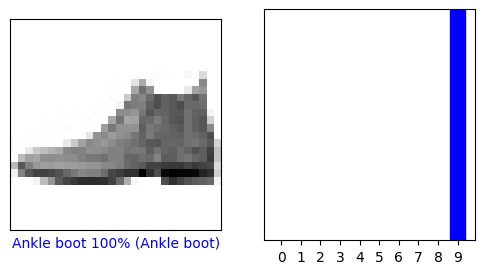

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

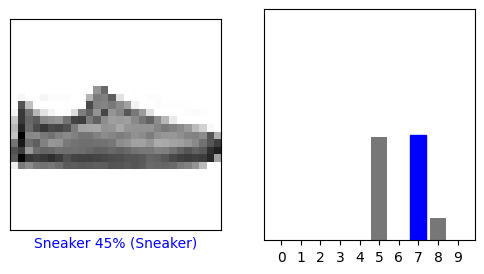

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Traçons plusieurs images avec leurs prédictions. Notez que le modèle peut se tromper même lorsqu'il est très confiant.

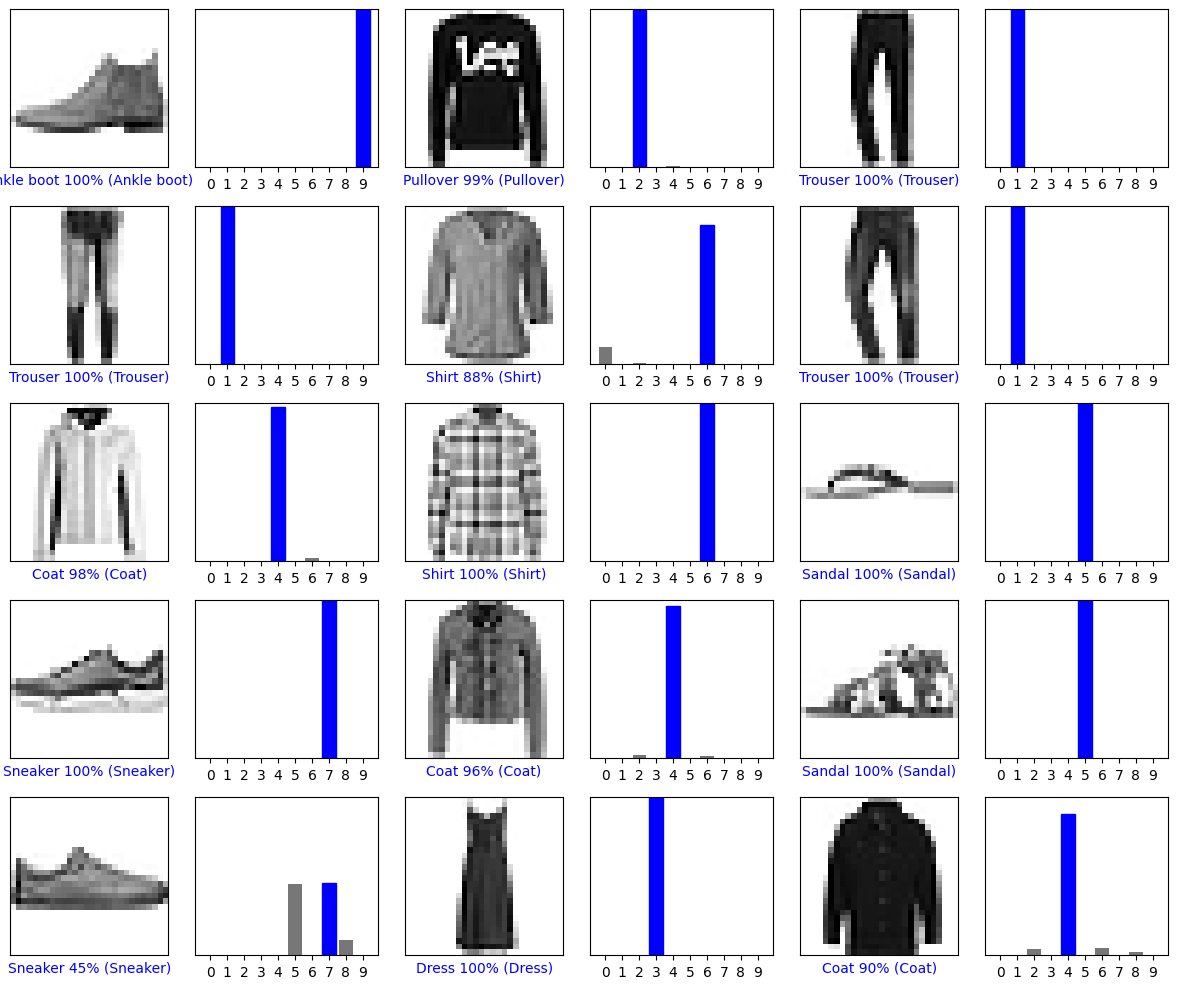

In [24]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Utiliser le modèle entraîné
Enfin, utilisez le modèle entraîné pour faire une prédiction sur une seule image.

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)


(28, 28)


Les modèles `tf.keras` sont optimisés pour effectuer des prédictions sur un *lot* (batch) ou une collection d'exemples à la fois. Par conséquent, même si vous utilisez une seule image, vous devez l'ajouter à une liste : 

In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


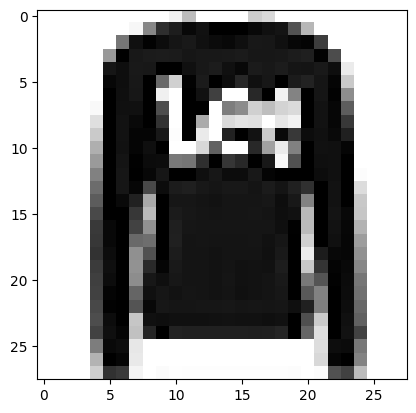

In [31]:
plt.imshow(img[0], cmap=plt.cm.binary)

Prédisez maintenant le bon libellé pour cette image :

In [27]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 25ms/step
[[7.2031175e-06 5.6449823e-10 9.9337500e-01 8.1136667e-11 5.7161101e-03
  1.6257122e-09 9.0160384e-04 4.0002734e-14 5.3994635e-09 5.0229799e-15]]


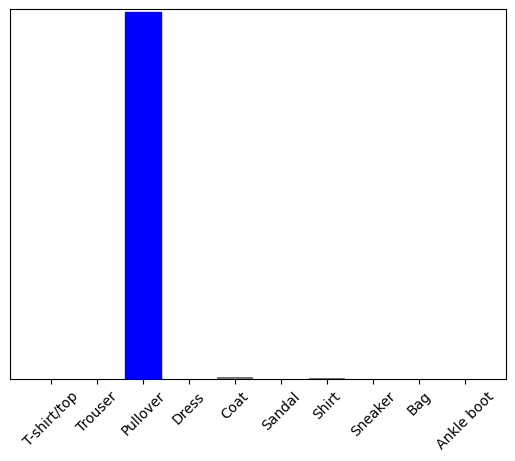

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` renvoie une liste de listes, une liste pour chaque image du lot de données. Saisissez les prédictions pour notre (seule) image dans le lot :

In [29]:
np.argmax(predictions_single[0])

2

Et le modèle prédit une étiquette comme prévu.

# Création d'un modèle avec un réseau convolutionnel (CNN)

Comme nous avons vu précédemment, le réseau présenté ci-dessus est de type **dense**, c'est-à-dire, chaque neurone d'une couche est connecté à la sortie de tous les neurones de la couche précédente.

Ce type de construction peut avoir des problèmes de performance si le nombre de neurones/pixels est trop important. De plus, on *fige* les poids sur des parties spécifiques de l'image, ce qui peut gêner la classification si l'image comporte de variations.

Dans cette section nous allons faire usage de couches de convolution et de pooling afin d'alléger le modèle et le rendre plus flexible.

Pour ce nouveau modèle, on utiliser les éléments suivants :

* **convolutions** `tf.keras.layers.Conv2D` et `MaxPooling2D` - Le réseau commence par deux paires de Conv/MaxPool. La première couche est une convolution Conv2D avec des filtres (3,3) appliqués à l'image d'entrée. Elle  conserve la taille d'image d'origine en utilisant le remplissage (padding), et crée 32 images de sortie (convoluées) (cette couche crée donc 32 images convoluées de la même taille que l'entrée). 
Ensuite, les 32 sorties sont réduites de taille en utilisant un MaxPooling2D (2,2) avec un décalage de 2. La couche Conv2D suivante a également un noyau (3,3). Elle prend les 32 images en entrée et crée 64 sorties qui sont à nouveau réduites de taille par une couche MaxPooling2D. 

* **sortie** `tf.keras.layers.Dense` - C'est une couche de 128 neurones suivie d'une couche **softmax** à 10 nœuds. Chaque nœud représente une classe de vêtement. La couche finale prend en entrée les 128 nœuds de la couche précédente et produit une valeur dans la plage [0, 1], représentant la probabilité que l'image appartienne à cette classe. La somme de toutes les valeurs des 10 nœuds est égale à 1.

In [47]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Comme précédemment, nous allons *compiler* le modèle en définissant certains paramètres (optimisateur, etc.). Notez qu'on a retiré l'option `(from_logits=True)` car la couche *softmax* est présente cette fois-ci.



In [50]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Tout d'abord, nous définissons le comportement des itérations pour l'ensemble de données d'entraînement :
1. Reutiliser le dataset indéfiniment en spécifiant `dataset.repeat()` (le paramètre `epochs` décrit ci-dessous limite la durée de l'entraînement).
2. `dataset.shuffle(60000)` randomise l'ordre des exemples afin que notre modèle ne puisse rien apprendre de l'ordre des exemples.
3. Et `dataset.batch(32)` indique à `model.fit` d'utiliser des lots de 32 images et étiquettes lors de la mise à jour des variables du modèle.

L'entraînement est effectué en appelant la méthode `model.fit` :
1. Fournissez les données d'entraînement au modèle en utilisant `train_dataset`.
2. Le modèle apprend à associer les images et les étiquettes.
3. Le paramètre `epochs=5` limite l'entraînement à 5 itérations complètes de l'ensemble de données d'entraînement, soit un total de 5 * 60000 = 300000 exemples.

In [41]:
import tensorflow_datasets as tfds
import math
tfds.disable_progress_bar()

dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [42]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [51]:
model2.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 20s 4ms/step - loss: 0.3974 - accuracy: 0.8574
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2598 - accuracy: 0.9044
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2108 - accuracy: 0.9223
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1820 - accuracy: 0.9321
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1557 - accuracy: 0.9430
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1300 - accuracy: 0.9520
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1121 - accuracy: 0.9585
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0926 - accuracy: 0.9668
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0803 - accuracy: 0.9710
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.06

À mesure que le modèle est entraîne, la perte et l'accuracy sont affichés. Ce modèle atteigne une accuracy autour de 0.97 (ou 97%) sur le dataset d'entraînement.

### Évaluer l'accuracy

Ensuite, comparez les performances du modèle sur l'ensemble de données de test :

In [53]:
test_loss, test_acc = model2.evaluate(test_dataset, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3335 - accuracy: 0.9161 - 1s/epoch - 4ms/step

Test accuracy: 0.916100025177002


Même s'il y a une perte par rapport à l'ensemble d'entraînement, ce modèle atteigne plus de 91% d'accuracy sur l'ensemble de test (environ 87% avec le modèle DNN).

## Effectuer des prédictions et explorer les résultats
Avec le modèle entraîné, nous pouvons faire des predictions avec des nouvelles images.

In [54]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model2.predict(test_images)

1/1 [==============================] - 0s 63ms/step


In [55]:
predictions.shape

(32, 10)

Ici, le modèle a prédit la probabilité de chaque étiquette pour chaque image de l'ensemble de tests. Jetons un coup d'œil à la première prédiction :

In [56]:
predictions[0]

array([1.6691956e-08, 2.8074139e-09, 4.9798441e-06, 5.0359956e-11,
       9.8810995e-01, 6.6022974e-13, 1.1885130e-02, 8.5293849e-13,
       1.0417753e-10, 9.2023938e-10], dtype=float32)

Une prédiction est un tableau de 10 nombres. Ils décrivent la "confiance" du modèle que l'image correspond à chacun des 10 différents articles vestimentaires. Nous pouvons voir quelle étiquette a la valeur de confiance la plus élevée :

In [57]:
np.argmax(predictions[0])

4

Le modèle est généralement le plus confiant que cette image est une chemise, ou `class_names[6]`. Vérifions l'étiquette :

In [58]:
test_labels[0]

4

Nous pouvons afficher l'ensemble des predictions pour les 10 classes

In [59]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Regardons les images 0 et 12, avec leur prédiction et array de probabilités.

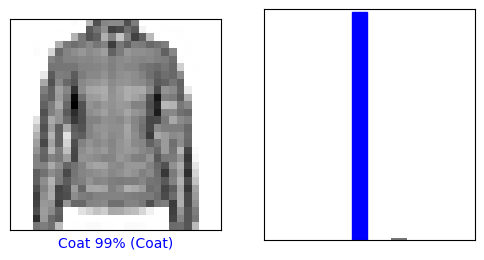

In [60]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

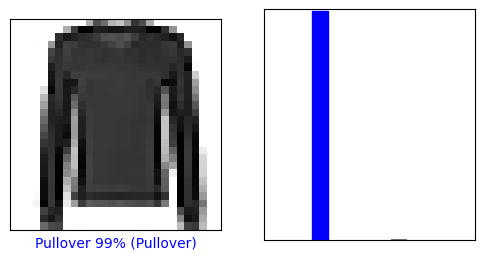

In [61]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Affichons plusieurs images avec leurs prédictions. Les étiquettes de prédiction correctes sont en bleu et les étiquettes de prédiction incorrectes sont en rouge. Le nombre indique le pourcentage (sur 100) pour l'étiquette prédite. Notez qu'il peut y avoir des erreurs même lorsque la confiance est très élevée.

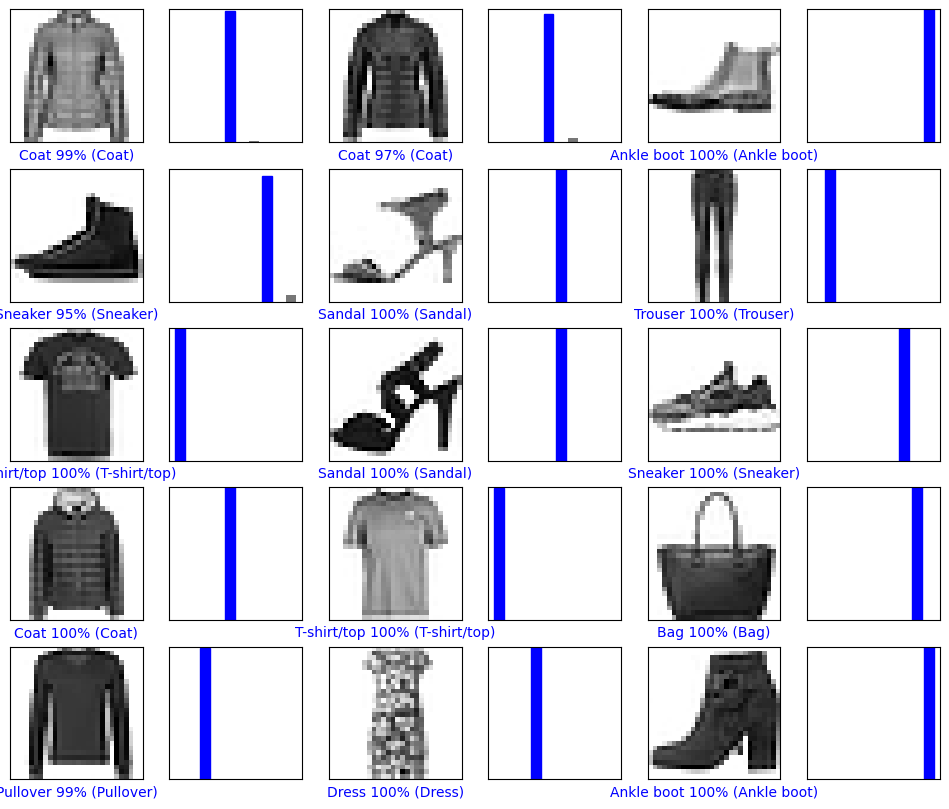

In [62]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## Utiliser le modèle entraîné
Enfin, utilisez le modèle entraîné pour faire une prédiction sur une seule image.

(28, 28, 1)


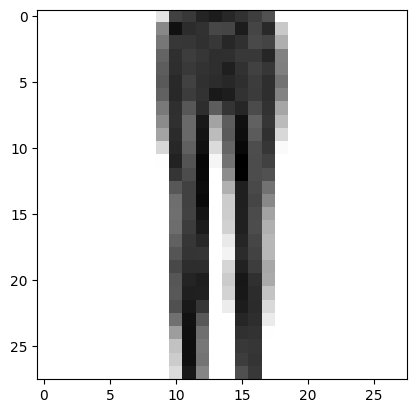

In [70]:
# Grab an image from the test dataset.
img = test_images[5]

print(img.shape)

plt.imshow(img, cmap=plt.cm.binary)



Les modèles `tf.keras` sont optimisés pour effectuer des prédictions sur un *lot* (batch) ou une collection d'exemples à la fois. Par conséquent, même si vous utilisez une seule image, vous devez l'ajouter à une liste : 

In [71]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Prédisez maintenant le bon libellé pour cette image :

In [75]:
predictions_single = model2.predict(img)
print(predictions_single)

1/1 [==============================] - 0s 474ms/step
[[1.8125481e-16 1.0000000e+00 1.0499902e-18 4.4252559e-14 7.5197171e-15
  1.5307688e-22 3.2759857e-15 4.4714419e-23 2.0466464e-21 3.6794110e-24]]


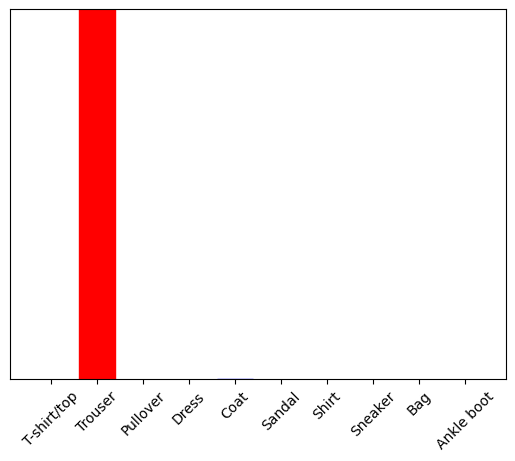

In [76]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`tf.keras.Model.predict` renvoie une liste de listes, une liste pour chaque image du lot de données. Saisissez les prédictions pour notre (seule) image dans le lot :

In [77]:
np.argmax(predictions_single[0])

1

Et le modèle prédit une étiquette 1 (Trouser) comme prévu.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.